# D213 Task 1 Advanced Data Analytics

## Part 1
### A1: Research Question

Given daily hospital revenue data can we detect seasonality and make future forecasts with a statistically significant level of confidence? 

### A2: Objectives

Given the business problem of hospital readmission's along with a time series data set related to hospital revenue our primary objective to gain insights into the overall trends and seasonality of the hospital revenue. These insights while not directly related readmission will give us another feature in future study of readmission data. A secondary objective of this analysis is to assess the feasibility of forcasting hospital revenue based on the given time series. The potential to forcast revenue has a broad range of applications ranging from further study of readmission data as well as organizational resource planning.

## Part 2

### B1: Assumptions

**Autocorrelation**: This assumption is satisfied when given data points in a series are correlated with lag points in the same series in a consistent manner across time. The consistency of this correlation must be statistically significant. 


**Stationarity**: The assumption requires that the statistical characteristics of the data remain constant over the passing of time. This means that measures such as the autocorrelation, variance, and mean should remain consistent throughout the data set. If the data does not satisfy this assumption it must be remedied before moving forward with the application of the model.


In [400]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [401]:
df = pd.read_csv('./medical_data.csv')
data_base = df.copy()

df.head()

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


In [402]:
df.shape

(731, 2)

In [403]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Day,731.0,366.000000,211.165812,1.000000,183.500000,366.00000,548.500000,731.000000
Revenue,731.0,14.179608,6.959905,-4.423299,11.121742,15.95183,19.293506,24.792249


In [404]:
# Displays that the series frequency is complete
days = set(df["Day"])
for i in range(1, len(df) + 1 ):
    if i not in days:
        print(i)

In [405]:
df.head()

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888



##  Part 3
### C1: Line Graph Display 

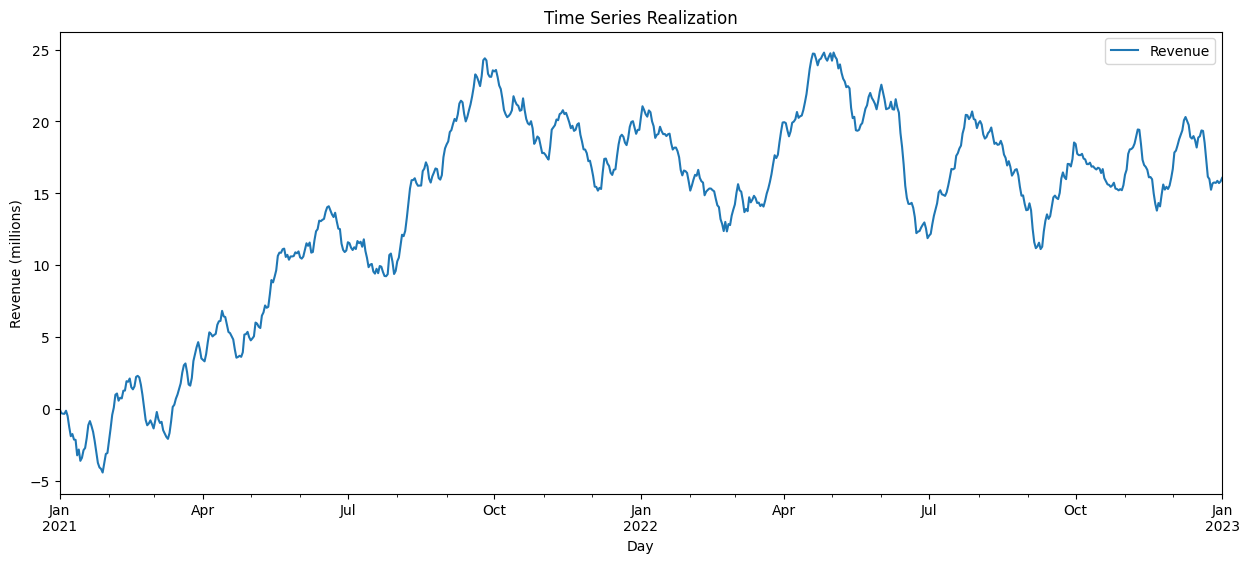

In [406]:
# Sets an arbitrary date range as the index
date_range = pd.date_range(start='2021-1-1', periods=len(df), freq='D')
df = df.set_index(date_range)

# Drops the Day column we can do this confidently since there are no missing days in the series
df.drop(columns=['Day'], inplace=True)

# Generate and save plot
df.plot(title='Time Series Realization', ylabel='Revenue (millions)', xlabel='Day', figsize=(15, 6))
plt.savefig('medical_revenue_plot.png', dpi=300)
plt.show()

### C2: Step Formatting

This time series utilizes 731 consecutive Days as the step format. There frequency of the data points (days) is complete with no missing days within the series as shown in the loop above.

### C3: Evaluation of Stationarity

To evaluate the stationarity of the given time series data we will use an Augmented Dicky Fuller test. This test will determine the level to which the mean and variance changes over time. To evaluate the results we will look primarily at the p-value  and ADF statistic.

**ADF Statistic**: If the ADF statistic is less than the critical value at the desired significance level we can determine that the data is stationary. If the ADF statistic is greater than the critical value for the desired significance we must determine that the data is not stationary.

**P-Value**: If the p value falls bellow the selected significance (.05) in our case we can determine that the data is stationary. If the p value is greater than the selected significance the data will show to be non-stationary.

In [407]:
# Dicky Fuller Test
result = adfuller(df['Revenue'])
print("✅ Data is stationary") if result[1] <= 0.05 else  print("🔺 Data is not stationary")
print('ADF statistic:', result[0])
print('p-value:', result[1])
print('critical values:', result[4])


🔺 Data is not stationary
ADF statistic: -2.218319047608946
p-value: 0.19966400615064328
critical values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


### C4: Steps to Prepare Data

1. Creating a datetime index based on the days feature of the original data set.
2. Correct the stationarity of the data set. to do this we will take the difference using the builtin pandas `.diff` method with the default lag of 1. We then test this revenue diff column fot stationarity.
3. Validate that there is only 1 NA value created by taking the diff. The one NA value should be the first as it does not have a lag value.
4. Dropping the NA values in the data using the builtin `.dropna` method in pandas. Again this should only drop the initial record.
5. Split data into test and training datasets. Utilizing the first 75% of datapoints as the training dataset reserving the remainder for testing.


In [408]:
# Difference the time series and plot to line graph
df['Revenue_d'] = df['Revenue'].diff()
df.head()

,Revenue,Revenue_d
2021-01-01,0.000000,NaN
2021-01-02,-0.292356,-0.292356
2021-01-03,-0.327772,-0.035416
2021-01-04,-0.339987,-0.012215
2021-01-05,-0.124888,0.215100


In [409]:
# count the number of NA values
df['Revenue_d'].isna().sum()

1

In [410]:
# Drop NA values
df.dropna(inplace=True)

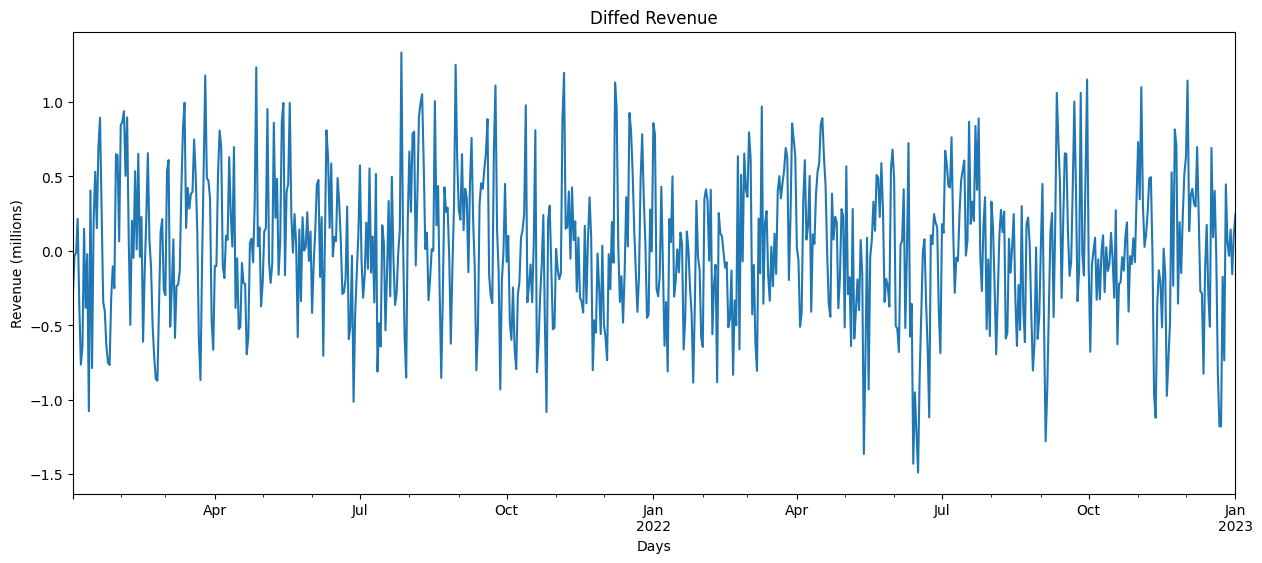

In [411]:
# Graph the difference revenue value to visually inspect for stationarity
df['Revenue_d'].plot(title='Diffed Revenue', ylabel='Revenue (millions)', xlabel='Days', figsize=(15, 6))
plt.show()

In [412]:
# Evaluate the stationarity of the newly diffed value 
result = adfuller(df['Revenue_d'])
print("✅ Data is stationary") if result[1] <= 0.05 else  print("🔺Data is not stationary")
print('ADF statistic:', result[0])
print('p-value:', result[1])
print('critical values:', result[4])

✅ Data is stationary
ADF statistic: -17.374772303557066
p-value: 5.113206978840171e-30
critical values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [413]:
df.head()

,Revenue,Revenue_d
2021-01-02,-0.292356,-0.292356
2021-01-03,-0.327772,-0.035416
2021-01-04,-0.339987,-0.012215
2021-01-05,-0.124888,0.215100
2021-01-06,-0.491590,-0.366702


In [414]:
# Train Test Split
split_index = int(0.75 * len(df))
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

print(f'test dataframe length: {test_df.shape[0]}')
print(f'train dataframe length: {train_df.shape[0]}')

test dataframe length: 183
train dataframe length: 547


## C5. Export clean dataset

Attached to submission

In [415]:
df.to_csv('./clean_time_series_dataset.csv')
test_df.to_csv('./test_dataset.csv')
train_df.to_csv('./train_dataset.csv')

# APPENDIX

In [416]:
type(df)

pandas.core.frame.DataFrame

<Figure size 150000x600 with 0 Axes>

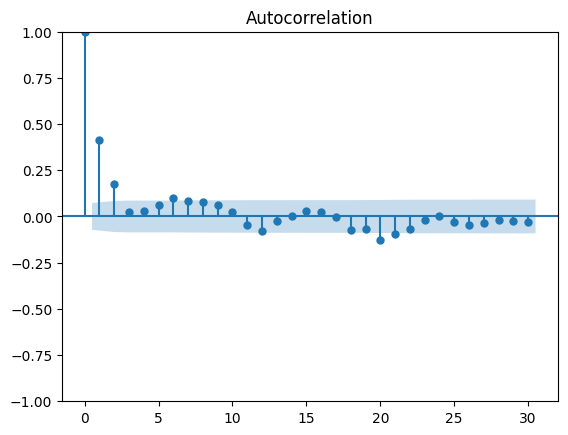

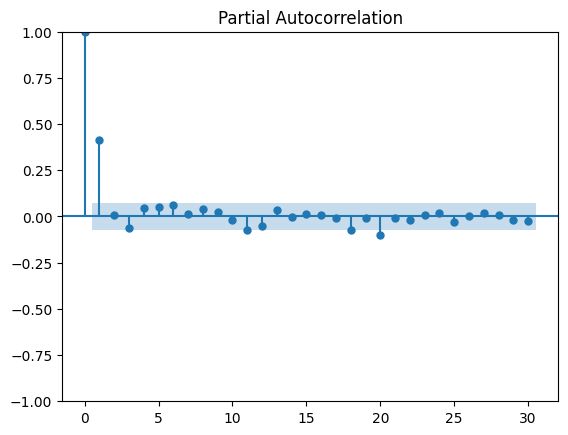

In [417]:
plt.figure(figsize=(1500, 6))
plot_acf(df["Revenue_d"].dropna(), lags=30)
plot_pacf(df["Revenue_d"].dropna(), lags=30)
plt.show()

In [418]:
model = SARIMAX(df["Revenue"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
result = model.fit(disp=False)

In [419]:
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -455.370
Date:                            Sun, 17 Sep 2023   AIC                            920.741
Time:                                    18:57:16   BIC                            943.616
Sample:                                01-02-2021   HQIC                           929.574
                                     - 01-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4355      0.085      5.121      0.000       0.269       0.602
ma.L1         -0.0211      0.094   